#Credit Card Fraud

# Classifying Credit Card Fraud -- Part I

The goal of this project is to predict fraudulent credit card transations using the Credit Card Fraud data in Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud/data). The predictors have been anonymized by PCA.

The data in this data set are imbalanced. I.e., there are about 500 fraudulent transactions vs. 300,000 non-fraudulent transactions (a rate of 0.2%). Correctly classifying fraudulent transactions becomes more challenging because typical classifiers can achieve 99.8% accuracy by classifying every transaction as non-fraudulent.

For the sake of decision-making, this project will use the following implicit
weights:

Cost of a False Negative = 4

Cost of a False Positive = 1

We are willing to falsely flag 4 transactions as fraudulent in order to catch 1.
That is, we are willing to accept a Positive Predictive Value (PPV) as low as 20%.


There is an initial analysis in R. This script picks up where the R version left
off, as computational speed was a limiting factor. These Jupyter Notebooks are more complete.

In [14]:
import os
os.getcwd()


'C:\\Users\\alexa\\Documents\\Python\\Credit_Fraud-Kaggle'

In [ ]:
os.chdir('Python/Credit_Fraud-Kaggle')

## Read in Data

In [15]:
# Import libraries; set a seed for all models
import random
rand_state = 123456
random.seed(rand_state)
from Credit_Fraud_functions import *

In [16]:
credit_1 = pd.read_csv('Data/creditcard_1.csv')
credit_2 = pd.read_csv('Data/creditcard_2.csv')
credit = credit_1.append(credit_2, ignore_index=True)
del credit_1, credit_2    # Free up some memory

In [19]:
print(credit[credit.isnull().any(axis=1)])
credit = credit.dropna()


        Time        V1        V2        V3        V4       V5        V6  \
153758   NaN -1.408633 -1.624698  2.547742  0.385672  0.50279  0.507195   

              V7        V8        V9  ...         V21       V22       V23  \
153758 -1.744431  0.760594  3.001704  ...    0.217641  0.758247  0.281254   

             V24       V25      V26       V27       V28  Amount  Class  
153758  0.736608 -0.741402  0.25535  0.141944  0.228167    49.5      0  

[1 rows x 31 columns]


### Some Exploratory data analysis. 

These data are composed of anonymized variables that have been reduced by PCA. For that reason descriptive stats aren’t as important to us as they would normally be, since we have absolutelyno way of interpreting them.

There are two variables that are not PCA transformed-- `Time` and `Amount`


Here is `Time`:

C:\Users\alexa\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


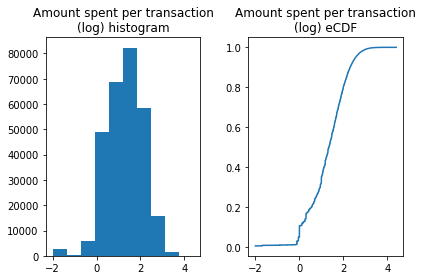

In [17]:
hist_ecdf(np.log10(credit['Amount'] + 0.01), 'Amount spent per transaction (log)')

The amount spent is log-normally distributed. Most transactions are very small, but some are very large. Larger transactions may(?) be more associated with fraud.


`Time` represents seconds since 12AM (time 0), spanning over a 48 hour period.

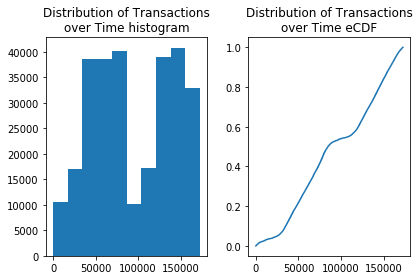

In [20]:
hist_ecdf(credit['Time'], 'Distribution of Transactions over Time')

Create a new variable that converts these time diffs to hour of the day (as floats)

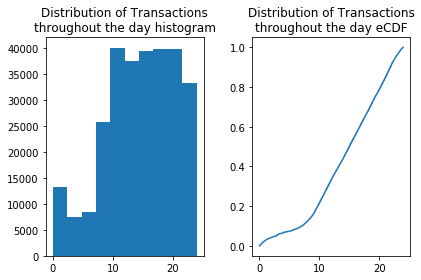

In [21]:
mask = credit['Time'] > 86400
credit['time_of_day'] = np.where(credit['Time'] > 86400,
                                 (credit['Time'] - 86400) / 3600,
                                 credit['Time'] / 3600)
credit = credit.drop('Time', axis=1)

hist_ecdf(credit['time_of_day'], 'Distribution of Transactions throughout the day')

## Data Partitioning

Split the data into train (70%), dev, and test sets (15% each)

In [22]:
from sklearn.model_selection import train_test_split

credit_train, temp = train_test_split(credit, test_size=0.3, stratify=credit['Class'])
credit_dev, credit_test = train_test_split(temp, test_size=0.5, stratify=temp['Class'])

# Split response (y) variable from predictors (X)
credit_train_x = credit_train.drop('Class', 1)
credit_train_y = credit_train['Class']

credit_dev_x = credit_dev.drop('Class', 1)
credit_dev_y = credit_dev['Class']

credit_test_x = credit_test.drop('Class', 1)
credit_test_y = credit_test['Class']


## Sampling Techniques for Imbalanced Classes

These data are highly imbalanced. Only 0.2% of observations are fraud. The main goal of this Notebook is to test out some different sampling methods and see how they perform.

To limit computational resources, I'm only going to use a lasso logistic regression for each in order to see which produce the best (least awful) results. I will carry over the most promising sampling methods into future analyses and train different types of classification models.



### Undersampling

In [23]:
# Generate undersampled data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=rand_state, replacement=False)
credit_train_x_undersampled, credit_train_y_undersampled = rus.fit_sample(credit_train_x, credit_train_y)
print(credit_train_x_undersampled.shape)

(688, 30)


In [24]:
# Perform a L1 penalized logistics regression grid search for lambda
param_grid = [{'C': [0.001, 0.0015, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1']}]
scores = ['f1_macro']

In [28]:
# This function is a simple wrapper around sk-learn functions (Credit_Fraud_functions.py)
# It performs a grid search using provided parameters and prints the results.
# Prints training metrics for each combination of parameters and tests the
# best training model against the dev set.
clf_log_under = auto_grid_search_clf(x_train=credit_train_x_undersampled,
                                     y_train=credit_train_y_undersampled,
                                     parameter_grid=param_grid,
                                     x_test=credit_dev_x,
                                     y_test=credit_dev_y,
                                     metrics=scores)

C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best Parameters
{'C': 1, 'penalty': 'l1'}
f1_macro: Mean, sd, Parameters
0.3244 (+/-0.0186) for {'C': 0.001, 'penalty': 'l1'}
0.6745 (+/-0.0922) for {'C': 0.0015, 'penalty': 'l1'}
0.9153 (+/-0.0613) for {'C': 0.01, 'penalty': 'l1'}
0.9316 (+/-0.0346) for {'C': 0.1, 'penalty': 'l1'}
0.9345 (+/-0.0387) for {'C': 1, 'penalty': 'l1'}
0.9258 (+/-0.0413) for {'C': 10, 'penalty': 'l1'}
0.9244 (+/-0.0394) for {'C': 100, 'penalty': 'l1'}
0.9258 (+/-0.0413) for {'C': 1000, 'penalty': 'l1'}
0.9258 (+/-0.0413) for {'C': 10000, 'penalty': 'l1'}
             precision    recall  f1-score   support

          0       1.00      0.96      0.98     42647
          1       0.04      0.93      0.08        74

avg / total       1.00      0.96      0.98     42721



#### 

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(credit_dev_y, clf_log_under.predict(credit_dev_x))

NameError: name 'clf_log_under' is not defined

In [25]:
# This is a wrapper around some matplotlib code to reduce repetition.
plot_train_error(pd.Series(np.log10(param_grid[0]['C'])),
                 clf_log_under.cv_results_['mean_test_score'],
                 error=clf_log_under.cv_results_['std_test_score'],
                 xlab = 'log10(lambda)')

NameError: name 'clf_log_under' is not defined

#### Variable Importance 

In [ ]:
# Plot the coefficients
variable_names = pd.Series(credit_train_x.columns.values)
plot_varimp_logistic(clf_log_under, variable_names)

#### Precision vs. Recall Curve

In [ ]:
plot_precision_recall(clf_log_under.decision_function(credit_dev_x), credit_dev_y)

#### Naive Oversampling

In [ ]:
temp = credit_train[credit_train['Class'] == 1]
temp2 = credit_train[credit_train['Class'] == 0]
credit_train_cut = temp2.sample(n = 40000).append(temp, ignore_index = True)

credit_train_cut_x = credit_train_cut.drop('Class', 1)
credit_train_cut_y = credit_train_cut['Class']

In [ ]:

ros = RandomOverSampler(random_state=rand_state)
credit_train_x_oversampled, credit_train_y_oversampled = \
    ros.fit_sample(credit_train_cut_x, credit_train_cut_y)

print(credit_train_x_oversampled.shape)

In [ ]:
# Perform a L1 penalized logistics regression grid search for lambda
# Keep the same parameters as the undersampled model.
clf_log_over = auto_grid_search_clf(x_train=credit_train_x_oversampled,
                                     y_train=credit_train_y_oversampled,
                                     parameter_grid=param_grid,
                                     x_test=credit_dev_x,
                                     y_test=credit_dev_y,
                                     metrics=scores)

In [ ]:
## Confusion matrix
confusion_matrix(credit_dev_y, clf_log_under.predict(credit_dev_x))

In [ ]:
## Plot Performance vs. lambda
plot_train_error(pd.Series(np.log10(param_grid[0]['C'])),
                 clf_log_over.cv_results_['mean_test_score'],
                 error=clf_log_over.cv_results_['std_test_score'],
                 xlab = 'log10(lambda)')

In [ ]:
## Plot variable importance
plot_varimp_logistic(clf_log_over, variable_names)

In [ ]:
## Plot precision vs. recall curve
plot_precision_recall(clf_log_over.decision_function(credit_dev_x), credit_dev_y)

#### SMOTE Sampling -- Borderline2

SMOTE is synthetic minority oversmapling technique. It is an oversampling technique, but rather than replicating the minority class it creates new (synthetic) observations by interpolating values from existing observations.

The borderline method only uses samples that are 'in danger' (e.g., is classified correctly but has nearest neighbours of a different class) to generate the new observations. This is in contrast to default SMOTE, which may interpolate excessively between very easy 'inliers' (resulting in over-confidence in the decision boundary) and/or interpolate between inliers and outliers (resulting in a large influence of noise data)

In [ ]:
from imblearn.over_sampling import SMOTE

# Using the cut data with the original ~300,000 negative examples cut down
# to 40,000.
credit_train_x_smote, credit_train_y_smote = \
    SMOTE(kind='borderline2').fit_sample(credit_train_cut_x, credit_train_cut_y)
print(credit_train_x_smote.shape)


In [ ]:

# Perform a L1 penalized logistics regression grid search for lambda
# Keep the same parameters as the undersampled model.
clf_log_smote = auto_grid_search_clf(x_train=credit_train_x_smote,
                                     y_train=credit_train_y_smote,
                                     parameter_grid=param_grid,
                                     x_test=credit_dev_x,
                                     y_test=credit_dev_y,
                                     metrics=scores)

In [ ]:
## Confusion matrix
confusion_matrix(credit_dev_y, clf_log_under.predict(credit_dev_x))


In [ ]:
## Plot Performance vs. lambda
plot_train_error(pd.Series(np.log10(param_grid[0]['C'])),
                 clf_log_smote.cv_results_['mean_test_score'],
                 error=clf_log_smote.cv_results_['std_test_score'],
                 xlab = 'log10(lambda)')

In [ ]:
## Plot variable importance
plot_varimp_logistic(clf_log_smote, variable_names)

In [ ]:

## Plot precision vs. recall curve
plot_precision_recall(clf_log_smote.decision_function(credit_dev_x), credit_dev_y)

In [ ]:
credit_train_x_smote_svm, credit_train_y_smote_svm = \
    SMOTE(kind='svm').fit_sample(credit_train_cut_x, credit_train_cut_y)
print(credit_train_x_smote_svm.shape)

In [ ]:
# Perform a L1 penalized logistics regression grid search for lambda
# Keep the same parameters as the undersampled model.
clf_log_smote_svm = auto_grid_search_clf(x_train=credit_train_x_smote_svm,
                                     y_train=credit_train_y_smote_svm,
                                     parameter_grid=param_grid,
                                     x_test=credit_dev_x,
                                     y_test=credit_dev_y,
                                     metrics=scores)

In [ ]:

## Confusion matrix
confusion_matrix(credit_dev_y, clf_log_under.predict(credit_dev_x))

In [ ]:
## Plot Performance vs. lambda
plot_train_error(pd.Series(np.log10(param_grid[0]['C'])),
                 clf_log_smote_svm.cv_results_['mean_test_score'],
                 error=clf_log_smote_svm.cv_results_['std_test_score'],
                 xlab = 'log10(lambda)')


In [ ]:
## Plot variable importance
plot_varimp_logistic(clf_log_smote_svm, variable_names)

In [ ]:
## Plot precision vs. recall curve
plot_precision_recall(clf_log_smote_svm.decision_function(credit_dev_x), credit_dev_y)